# XGBoost model (AWS sagemaker)
In this project, we used the AWS sagemaker build-in XGBoost algorithm for classification prediction, and compared this result to regular XGBoost framework (regularizing gradient boosting framework), both predicted reults are similar. 

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import sklearn.model_selection

### EDA for training dataset

In [2]:
train_data = pd.read_csv('adult_trdata.csv', names=['age','workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
                                                     'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                                                     'hours-per-week', 'native-country', 'income'],sep=',\s', na_values=["?"],engine='python')
print(train_data.shape)
display(train_data.head())

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
train_data.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

In [4]:
new_train = train_data.dropna()
new_train.shape

(30162, 15)

In [5]:
# new_train['workclass'].value_counts()
# new_train['education'].value_counts()
# new_train['income'].value_counts()
# new_train.dtypes

<AxesSubplot:>

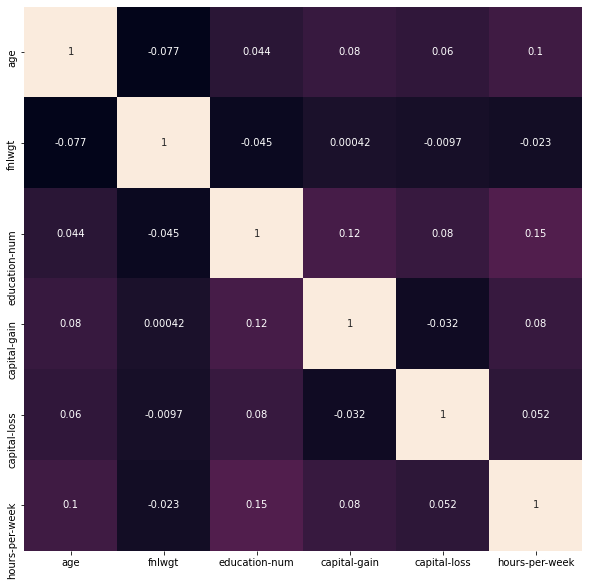

In [6]:
## Features Correlation analysis
plt.figure(figsize = (10, 10))
corr_matrix = new_train[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']].corr()
sns.heatmap(corr_matrix, annot = True, cbar = False)

In [7]:
# Dummy for categorical variables (training dataset)
def dummies(x):
    dummy = pd.get_dummies(new_train[x])
    new_train.drop(columns = x, inplace = True)
    return pd.concat([new_train, dummy], axis=1)

new_train = dummies('workclass')
new_train = dummies('education')
new_train = dummies('marital-status')
new_train = dummies('occupation')
new_train = dummies('relationship')
new_train = dummies('race')
new_train = dummies('sex')
new_train = dummies('native-country')
new_train.shape

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(30162, 105)

In [9]:
## Transfer column of income to binary.
new_train['income'] = new_train['income'].apply(lambda x:1 if x =='>=50K' or x =='>50K' else 0)
new_train.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income,Federal-gov,Local-gov,Private,...,Portugal,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'fnlwgt'}>],
       [<AxesSubplot:title={'center':'education-num'}>,
        <AxesSubplot:title={'center':'capital-gain'}>],
       [<AxesSubplot:title={'center':'capital-loss'}>,
        <AxesSubplot:title={'center':'hours-per-week'}>]], dtype=object)

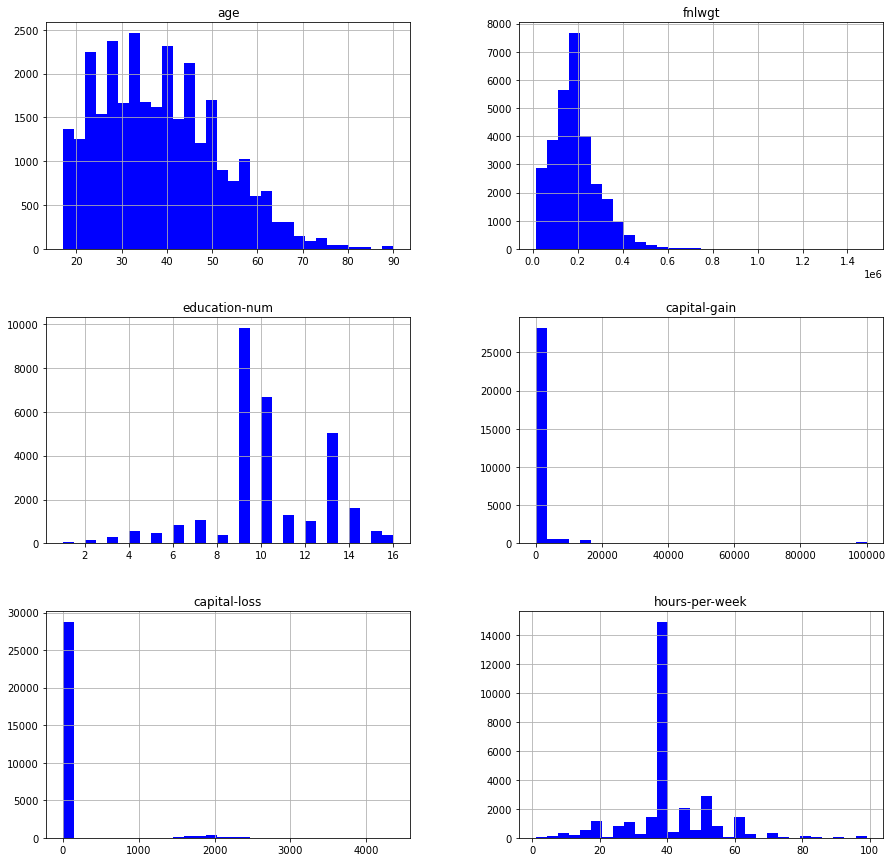

In [10]:
## Distribution 
new_train.iloc[:, :6].hist(bins = 30, figsize = (15,15), color = 'b')

## EDA for test dataset

In [11]:
test_dataRaw = pd.read_csv('adult_test.csv', names=['age','workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
                                                     'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                                                     'hours-per-week', 'native-country', 'income'], sep=',\s', na_values=["?"],engine='python')
print(test_dataRaw.shape)
test_data = test_dataRaw.drop([0])
print(test_data.shape)
test_data = test_data.reset_index(drop=True)
display(test_data.head())

(16282, 15)
(16281, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
1,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
2,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
3,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
4,18,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K.


In [12]:
test_data.isnull().sum()

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64

In [13]:
new_test = test_data.dropna()
new_test.shape

(15060, 15)

In [14]:
# new_test['workclass'].value_counts()
# new_test['education'].value_counts()
# new_test['income'].value_counts()

In [15]:
# Dummy for categorical variables (testing dataset)
def dummies_test(x):
    dummy_test = pd.get_dummies(new_test[x])
    new_test.drop(columns = x, inplace = True)
    return pd.concat([new_test, dummy_test], axis=1)

new_test = dummies_test('workclass')
new_test = dummies_test('education')
new_test = dummies_test('marital-status')
new_test = dummies_test('occupation')
new_test = dummies_test('relationship')
new_test = dummies_test('race')
new_test = dummies_test('sex')
new_test = dummies_test('native-country')
new_test.shape

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(15060, 104)

In [16]:
new_test.columns

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'income', 'Federal-gov', 'Local-gov', 'Private',
       ...
       'Portugal', 'Puerto-Rico', 'Scotland', 'South', 'Taiwan', 'Thailand',
       'Trinadad&Tobago', 'United-States', 'Vietnam', 'Yugoslavia'],
      dtype='object', length=104)

In [17]:
## Transfer column income to binary
new_test['income'] = new_test['income'].apply(lambda x:1 if x =='>=50K.' or x =='>50K.' else 0)
new_test.shape

(15060, 104)

In [18]:
## Check the column difference between train and test data
extra_column = [x for x in list(new_train.columns) if x not in list(new_test.columns)]
extra_column

['Holand-Netherlands']

In [19]:
## For same numbers of columns
new_test['Holand-Netherlands'] = 0
new_test.shape

(15060, 105)

In [20]:
new_test.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income,Federal-gov,Local-gov,Private,...,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia,Holand-Netherlands
0,25,226802.0,7.0,0.0,0.0,40.0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,38,89814.0,9.0,0.0,0.0,50.0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,28,336951.0,12.0,0.0,0.0,40.0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,44,160323.0,10.0,7688.0,0.0,40.0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
5,34,198693.0,6.0,0.0,0.0,30.0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


## XGBOOST Classifier Model (AWS SageMaker)

In [60]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

session = sagemaker.Session()

## represents the IAM role
role = sagemaker.get_execution_role()
# bucket = 'mytest-ai'
prefix = 'myTest-xgboost'

In [62]:
## Splitted into X/Y train, X/Y test and X/Y validation
X_train, Y_train = new_train.loc[:, new_train.columns !='income'].astype(np.float32), new_train[['income']].astype(np.float32)
X_test, Y_test = new_test.loc[:, new_test.columns !='income'].astype(np.float32), new_test[['income']].astype(np.float32)
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.33)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape, X_val.shape, Y_val.shape

((20208, 104), (20208, 1), (15060, 104), (15060, 1), (9954, 104), (9954, 1))

In [63]:
## Save the data locally (virtual machine)
data_dir = '../data/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

In [64]:
# Upload the test.csv, train.csv and validation.csv files (in data_dir) to S3.
test_location = None
val_location = None
train_location = None

# Solution:
test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

In [66]:
## Container
container = get_image_uri(session.boto_region_name, 'xgboost', '1.0-1')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [68]:
# Now Construct the estimator object.
xgb = 0
xgb = sagemaker.estimator.Estimator(container, # The image name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance to use for training
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=session) # The current SageMaker session

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [70]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='reg:squarederror',
                        early_stopping_rounds=10,
                        num_round=500)
# objective='binary:logistic'

In [72]:
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [73]:
## Fit model
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2021-10-15 22:34:29 Starting - Starting the training job...
2021-10-15 22:34:32 Starting - Launching requested ML instances......
2021-10-15 22:35:43 Starting - Preparing the instances for training.........
2021-10-15 22:37:17 Downloading - Downloading input data...
2021-10-15 22:37:53 Training - Downloading the training image...
2021-10-15 22:38:25 Training - Training image download completed. Training in progress..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[22:38:30] 20208x104 matrix with 2101632 entries loaded from

In [74]:
## Create a transformer object from the trained model.
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [75]:
## Start the transform job. 
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')
xgb_transformer.wait()

......................................[2021-10-15:22:45:25:INFO] No GPUs detected (normal if no gpus installed)
[2021-10-15:22:45:25:INFO] No GPUs detected (normal if no gpus installed)
[2021-10-15:22:45:25:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }

    location / {
      return 404 "{}";
    }

  }
}


[2021-10-15 22:45:25 +0000] [17] [I

In [76]:
## Remove the loaded data and folder.
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-928066657719/sagemaker-xgboost-2021-10-15-22-39-13-543/test.csv.out to ../data/test.csv.out


In [77]:
predictions = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)
predictions = [round(num) for num in predictions.squeeze().values]

In [80]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, predictions)

0.8593625498007968

### The result is similar to the regular XGBoost model.